# Problem definition
A month ago it came out that I inherited an old haunted Library which was closed since around 1900. When I visited the library and opened the door it turned out that the area's been a mess. Since I love books I decided to clean the place and open it for everyones usage. The problem was that half of the books did not have a cover so I was not able to categorize them in any way. In the will it was written that the books were only written by one of the three authors - Edgar Allan Poe, Mary Shelley, HP Lovecraft. To create covers and organize the library I need to create a machine learning model that will predict the author base on the content of the book.

## Files descriptions:

books.csv - the training set

Data:

id - a unique identifier for each sentence

text - some text written by one of the authors

author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

In [33]:
# important libraries
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pickle
import seaborn as sns
import string

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [34]:
# Import and describe data set
df = pd.read_csv('books.csv')

df.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id26436,But as leaving time obviously approached I con...,EAP
freq,1,1,7900


## Comment
There is 19579 unique sentences coming from one of the 3 authors. The most sentences in the data set are coming from Edgar Allan Paul

In [35]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [78]:
# Check if there are null values
df.isnull().values.any()

False

## Comment
There are no null values in the dataset

In [37]:
# Make all words in sencences lowercase to further analysis
df.text = df.text.str.lower()

In [38]:
# Distribution of books in the dataset
def distribution_graph(x_values, title, x_label, y_label):
    plt.figure(figsize=(10,8))
    ax = x_values.value_counts().plot(kind='bar')
    
    plt.title(title, size=20)
    plt.xticks(rotation=0, size=15)
    plt.xlabel(x_label, size=15)
    plt.yticks(size=15)
    plt.ylabel(y_label, size=15)
    plt.grid(axis='y',linewidth=0.2)
    
    for i in ax.patches:
        ax.annotate(str(round(i.get_height())),(i.get_x(), i.get_height()), size=20, ha='left',
                va='bottom')

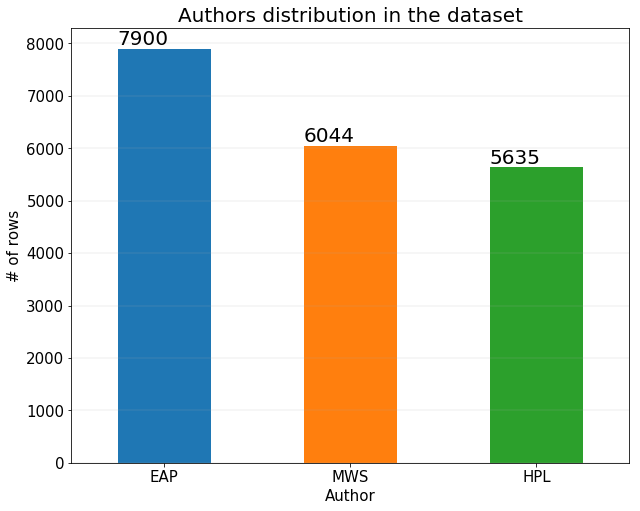

In [39]:
distribution_graph(df['author'], "Authors distribution in the dataset", "Author", "# of rows")    
plt.show()

## Comment
The most sentences are coming from books written by EAP. However this distribution should not impact the modeling so we will use this data for furhter analysis.

In [40]:
# Words in senteces distribution
## Prepare datasets
eap_text = df[df.author=="EAP"]["text"].values
hpl_text = df[df.author=="HPL"]["text"].values
mws_text = df[df.author=="MWS"]["text"].values

## Wordcloud graphs
def wordscloud_graph(text, max_words, title):
    plt.figure(figsize=(10,8))
    wc = WordCloud(background_color="black", max_words=max_words, 
                   stopwords=STOPWORDS, max_font_size= 40)
    wc.generate(" ".join(text))
    plt.title(title, fontsize=20)
    plt.imshow(wc.recolor(random_state=17), alpha=0.98)
    plt.axis('off')

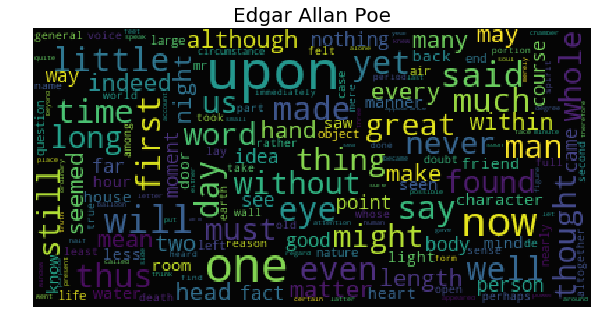

In [41]:
wordscloud_graph(eap_text, 800, "Edgar Allan Poe")

## Comment
In sentences written by Edgar Allan Poe the most visible words are "upon","one","first","man" . Thinking about horror books it looks like he was writing about situations that happen between people. As we know he started shaping how criminals look these days and somehow it is visible in his words.

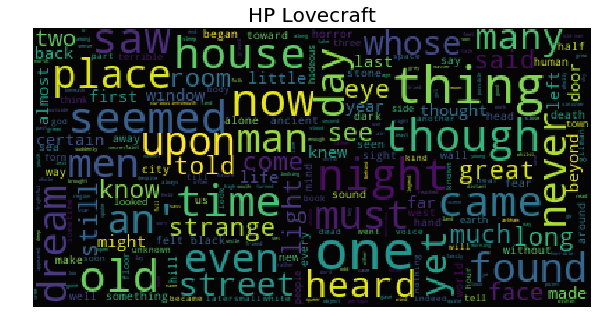

In [42]:
wordscloud_graph(hpl_text, 800, "HP Lovecraft")

## Comment
In sentences written by HP Lovecraft the most visible words are "now","one","found","house", "heard", "place" - it is looks like HP Lovecraft likes to write about places or which are hounted.

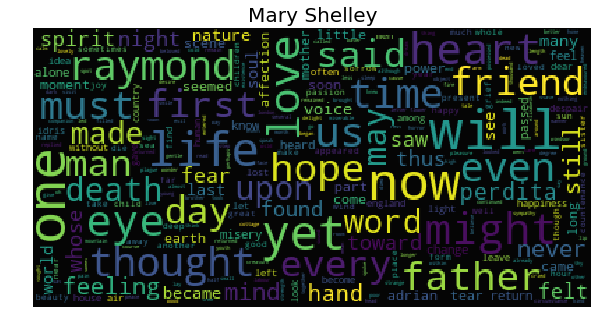

In [43]:
wordscloud_graph(mws_text, 800, "Mary Shelley")

## Comment

In sentences written by Mary Shelley the most visible words are "now","love","life","Raymond", "father"- it  looks like Mary Shelley likes to write about love and life and what happens when it is mnissing.

In [44]:
# Quantity graph to check the characters distribution
def quantity_graph(x_values, title):
    all_chars = x_values.str.split(expand=True).unstack().value_counts()
    top_chars = all_chars.head(50).to_frame().reset_index().rename(columns={'index': 'char', 0: 'quantity'})

    plt.figure(figsize=(20,8))
    sns.barplot(x=top_chars['char'], y=top_chars['quantity'])
    
    plt.title(title, size = 20)
    plt.xticks(rotation=90, size=15)
    plt.xlabel("")
    plt.yticks(rotation=0, size=15)
    plt.ylabel("quantity", size = 15)
    plt.grid(axis='y',linewidth=0.2)

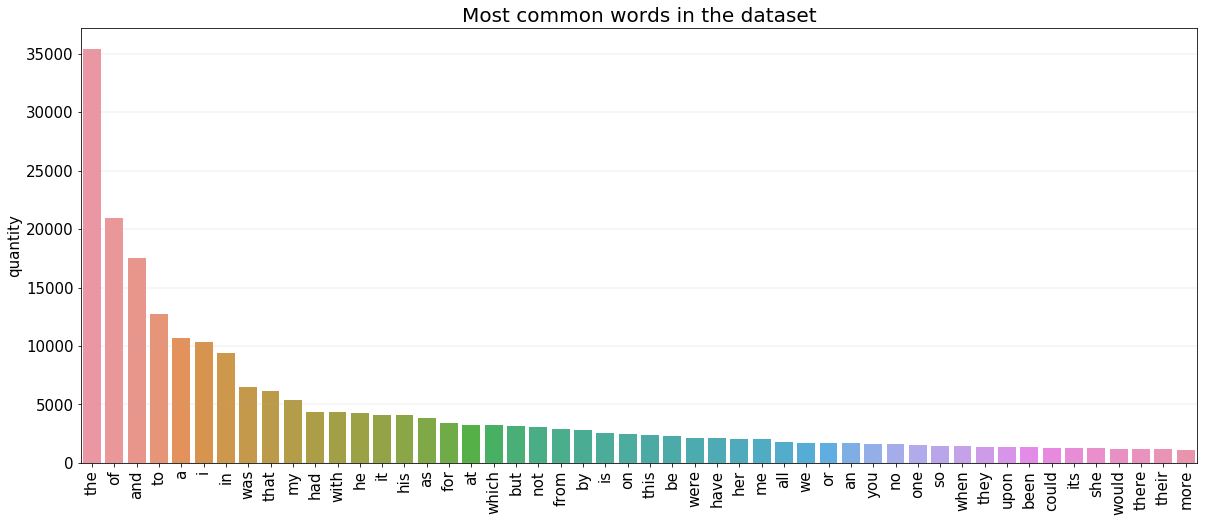

In [45]:
quantity_graph(df['text'], "Most common words in the dataset")
plt.show()

## Comment
As expected most common words are the stopwords like "the", "of", "and", "I".

In [46]:
# Datasetns to check how the words distribution differs between authors
df_eap = df[df.author=="EAP"]
df_hpl = df[df.author=="HPL"]
df_mws = df[df.author=="MWS"]

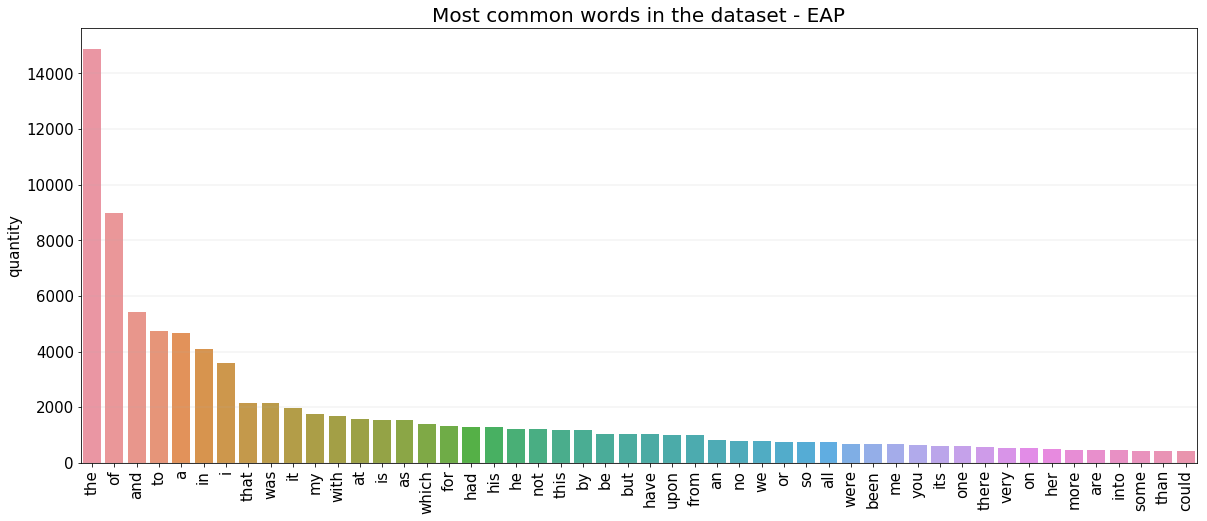

In [47]:
quantity_graph(df_eap['text'], "Most common words in the dataset - EAP")
plt.show()

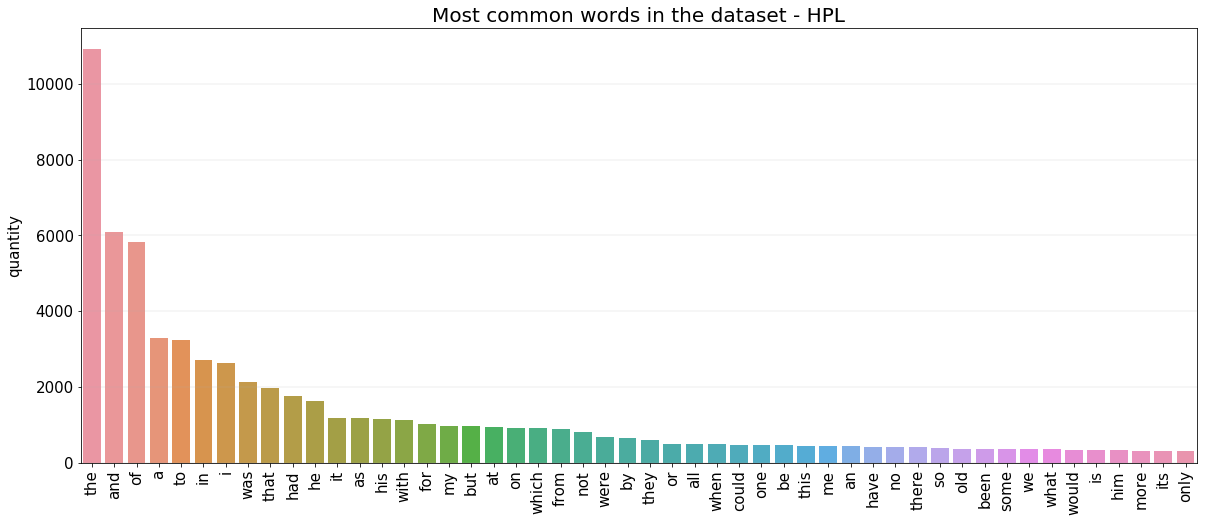

In [48]:
quantity_graph(df_hpl['text'], "Most common words in the dataset - HPL")
plt.show()

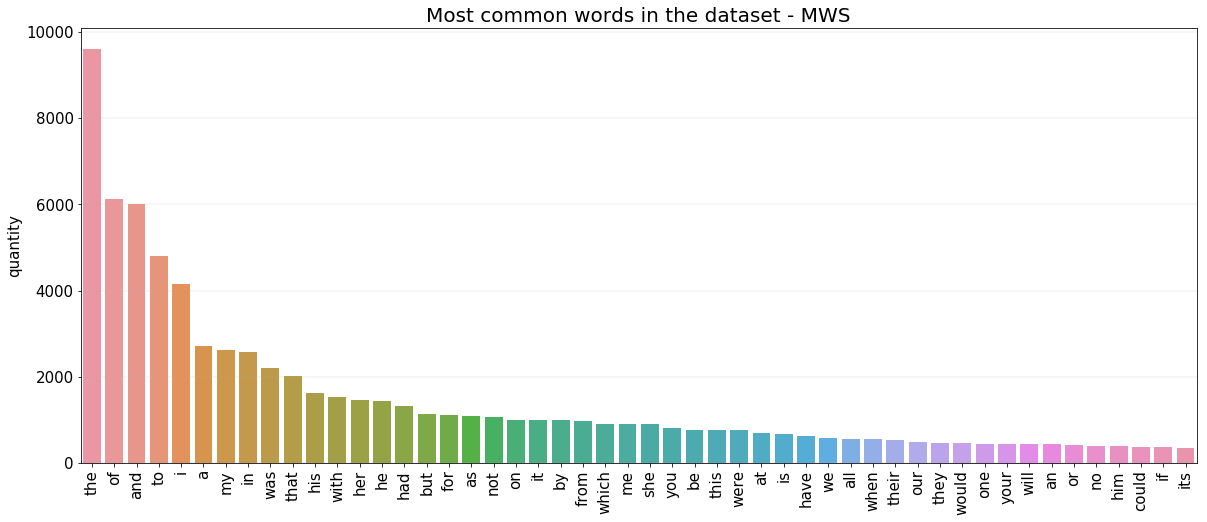

In [49]:
quantity_graph(df_mws['text'], "Most common words in the dataset - MWS")
plt.show()

## Comment 
As expected there are no difference between authors about words distribution.

In [50]:
# Tokenize and clean the data from stopwords
## Create stopwords
stopwords = nltk.corpus.stopwords.words('english')

## Function to clean the data
def clean_text(text):
    t_text_tokenized_list=[]
    t_text_cleaned_list=[]

    # Create lists containing split and cleaned words from sentences in text
    for i in text:
        t_text = nltk.word_tokenize(i)
        t_text_tokenized_list.append(t_text)
        t_text_cleaned = [word for word in t_text if word not in stopwords]
        t_text_cleaned_list.append(t_text_cleaned)
    
    return(t_text_tokenized_list, t_text_cleaned_list)

In [51]:
# Run the function
df['list_tokenize'], df['list_cleaned'] = clean_text(df.text)
df.head()

,id,text,author,list_tokenize,list_cleaned
0,id26305,"this process, however, afforded me no means of...",EAP,"[this, process, ,, however, ,, afforded, me, n...","[process, ,, however, ,, afforded, means, asce..."
1,id17569,it never once occurred to me that the fumbling...,HPL,"[it, never, once, occurred, to, me, that, the,...","[never, occurred, fumbling, might, mere, mista..."
2,id11008,"in his left hand was a gold snuff box, from wh...",EAP,"[in, his, left, hand, was, a, gold, snuff, box...","[left, hand, gold, snuff, box, ,, ,, capered, ..."
3,id27763,how lovely is spring as we looked from windsor...,MWS,"[how, lovely, is, spring, as, we, looked, from...","[lovely, spring, looked, windsor, terrace, six..."
4,id12958,"finding nothing else, not even gold, the super...",HPL,"[finding, nothing, else, ,, not, even, gold, ,...","[finding, nothing, else, ,, even, gold, ,, sup..."


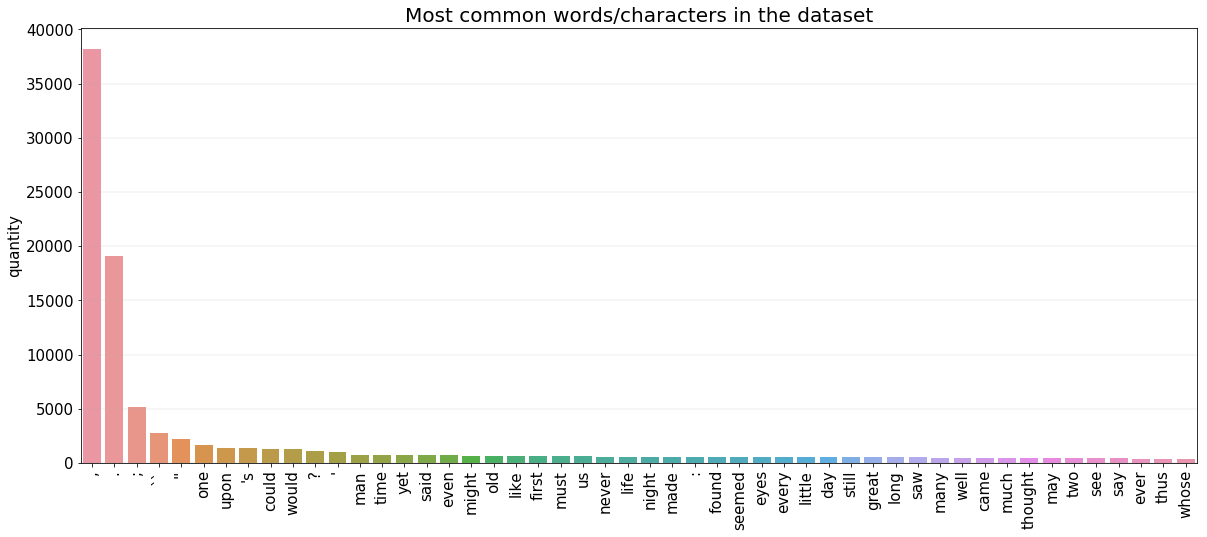

In [52]:
df['text_cleaned'] = df['list_cleaned'].apply(lambda x: ' '.join(x))

quantity_graph(df['text_cleaned'], "Most common words/characters in the dataset")
plt.show()

## Comment
After tokenizing the data and cleaning from stopwordsa we can see that the most common characters in sentences is punctuation. We need to remove it to see how the real words distribution look like.

In [53]:
# Remove puntuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['text_no_punct'] = df['text'].apply(remove_punctuation)

In [54]:
# Clean the data with no puntuation
df['list_tokenized_no_punct'], df['list_cleaned_no_punct'] = clean_text(df['text_no_punct'])
df.head()

,id,text,author,list_tokenize,list_cleaned,text_cleaned,text_no_punct,list_tokenized_no_punct,list_cleaned_no_punct
0,id26305,"this process, however, afforded me no means of...",EAP,"[this, process, ,, however, ,, afforded, me, n...","[process, ,, however, ,, afforded, means, asce...","process , however , afforded means ascertainin...",this process however afforded me no means of a...,"[this, process, however, afforded, me, no, mea...","[process, however, afforded, means, ascertaini..."
1,id17569,it never once occurred to me that the fumbling...,HPL,"[it, never, once, occurred, to, me, that, the,...","[never, occurred, fumbling, might, mere, mista...",never occurred fumbling might mere mistake .,it never once occurred to me that the fumbling...,"[it, never, once, occurred, to, me, that, the,...","[never, occurred, fumbling, might, mere, mistake]"
2,id11008,"in his left hand was a gold snuff box, from wh...",EAP,"[in, his, left, hand, was, a, gold, snuff, box...","[left, hand, gold, snuff, box, ,, ,, capered, ...","left hand gold snuff box , , capered hill , cu...",in his left hand was a gold snuff box from whi...,"[in, his, left, hand, was, a, gold, snuff, box...","[left, hand, gold, snuff, box, capered, hill, ..."
3,id27763,how lovely is spring as we looked from windsor...,MWS,"[how, lovely, is, spring, as, we, looked, from...","[lovely, spring, looked, windsor, terrace, six...",lovely spring looked windsor terrace sixteen f...,how lovely is spring as we looked from windsor...,"[how, lovely, is, spring, as, we, looked, from...","[lovely, spring, looked, windsor, terrace, six..."
4,id12958,"finding nothing else, not even gold, the super...",HPL,"[finding, nothing, else, ,, not, even, gold, ,...","[finding, nothing, else, ,, even, gold, ,, sup...","finding nothing else , even gold , superintend...",finding nothing else not even gold the superin...,"[finding, nothing, else, not, even, gold, the,...","[finding, nothing, else, even, gold, superinte..."


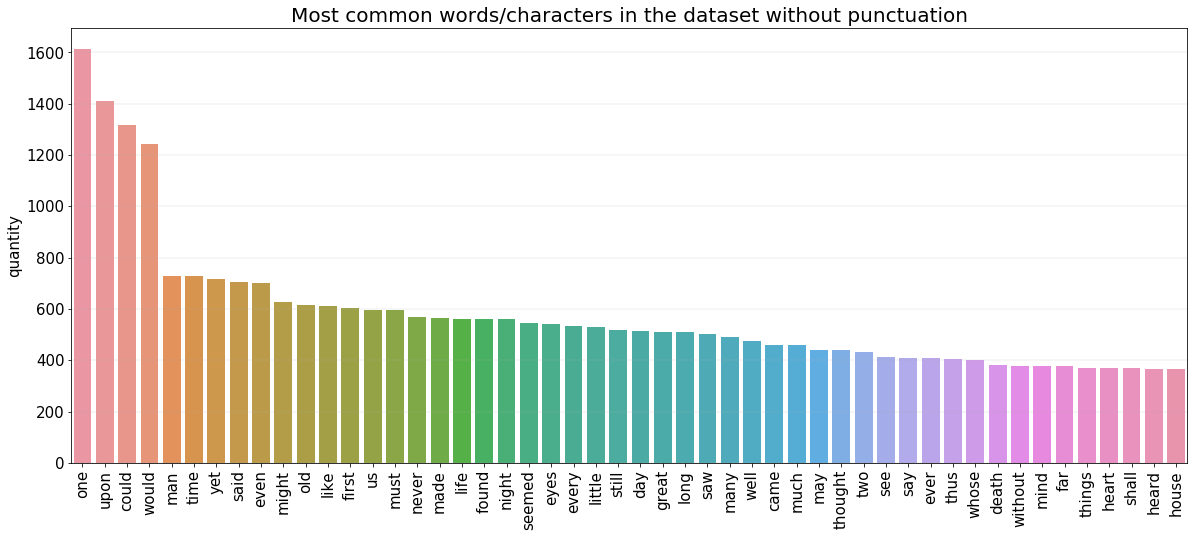

In [55]:
df['text_cleaned_no_punct'] = df['list_cleaned_no_punct'].apply(lambda x: ' '.join(x))

quantity_graph(df['text_cleaned_no_punct'], "Most common words/characters in the dataset without punctuation")
plt.show()

## Comment
Removing puntuation resulted in words distribution that is making more sense. Most cxommon words are: "one", "upon", "could/would", ""man", "time". Those words are not surprising because they indeed appear quite often in books.

In [57]:
# Check if it differs between authors
df_eap = df[df['author']=='EAP']
df_hpl = df[df['author']=='HPL']
df_mws = df[df['author']=='MWS']

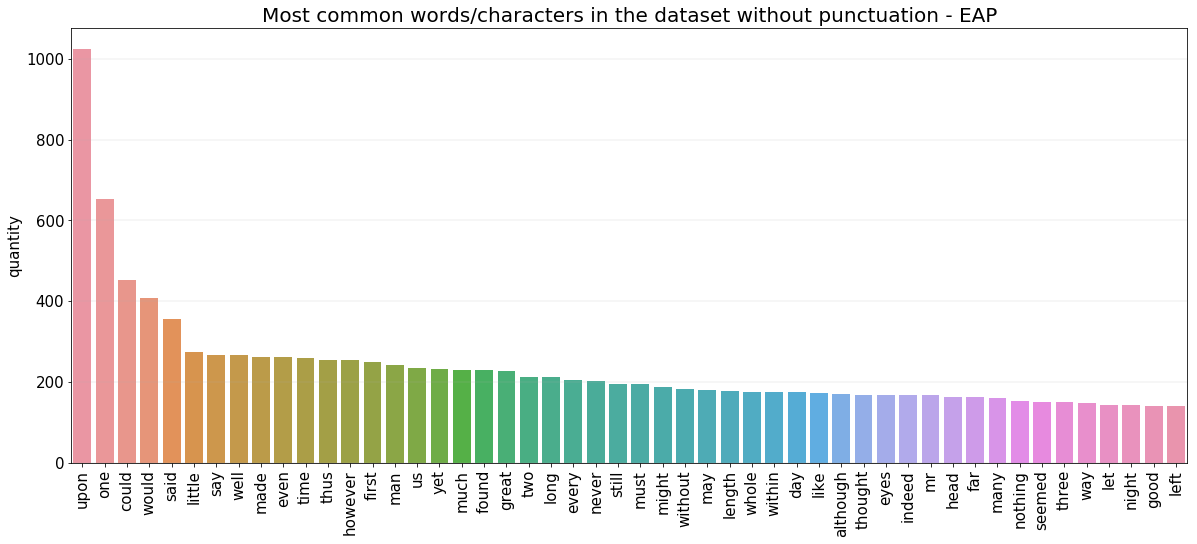

In [58]:
quantity_graph(df_eap['text_cleaned_no_punct'], "Most common words/characters in the dataset without punctuation - EAP")
plt.show()

## Comment
In snetences wirtten by EAP we observe that word like "upon" is dominating a lot. The other words that appear are "said", "little", "made". Unfortunately it does not indicate anything special.

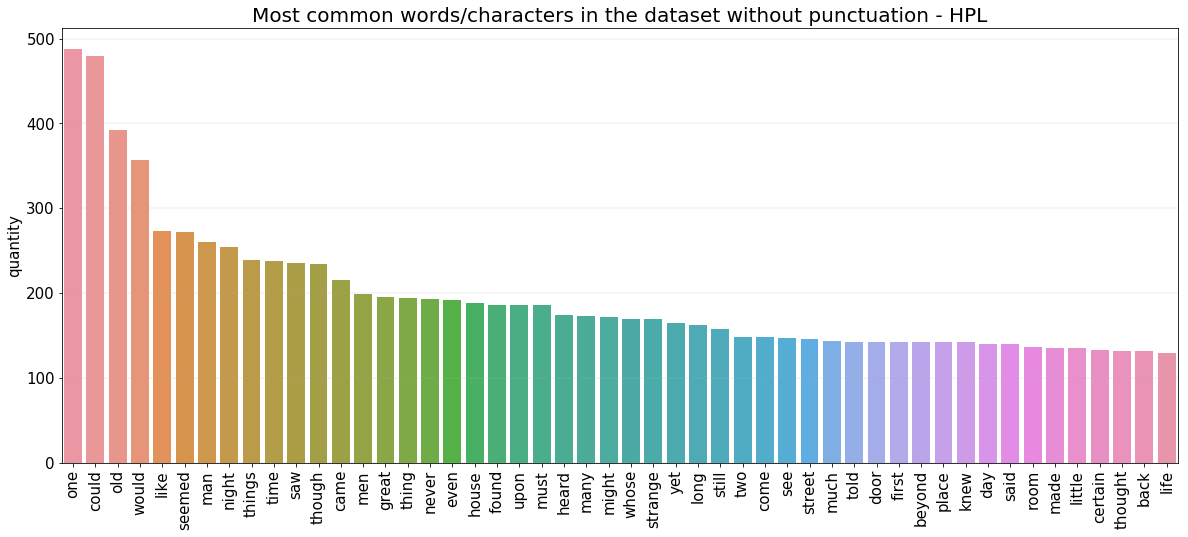

In [60]:
quantity_graph(df_hpl['text_cleaned_no_punct'], "Most common words/characters in the dataset without punctuation - HPL")
plt.show()

## Comment
In snetences wirtten by HPL we observe that word like "one", "could/would" are dominating a lot. The other words that appear are "old", "seemed", "man". It might indicates that ha was writing more about things that happened in past or about old man and what happened to him.

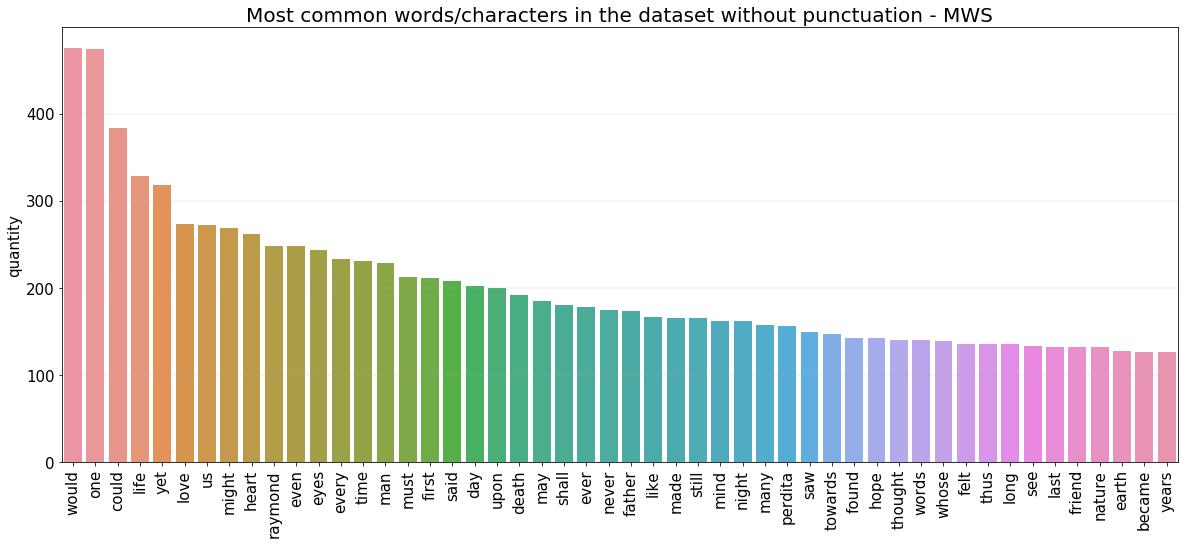

In [61]:
quantity_graph(df_mws['text_cleaned_no_punct'], "Most common words/characters in the dataset without punctuation - MWS")
plt.show()

## Comment
In snetences wirtten by MWS we observe that word slike "would" and "one" are dominating a lot. The other words that appear are "life", "love", "us". It shows that Mary was writing more about emotions and life.

# Feature engineering

In [62]:
# Are there other characteristincs which are different for authors
## boxplot graph to present the difference
def boxplot_graph(x_value, y_value, title, x_label, y_label, truncation):
    y_value = y_value.clip(upper=truncation) #truncation for better visuals
    
    plt.figure(figsize=(12,8))
    sns.boxplot(x=x_value, y=y_value)
    
    plt.title(title, fontsize=20)
    plt.xticks(size = 20)
    plt.xlabel(x_label, fontsize=12)
    plt.yticks(size = 20)
    plt.ylabel(y_label, fontsize=15)

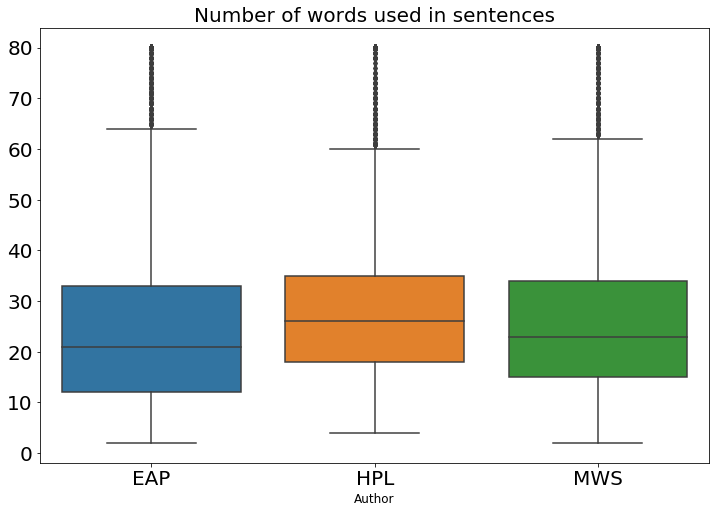

In [80]:
## Number of words in the text ##
df["num_words"] = df["text"].apply(lambda x: len(str(x).split()))

boxplot_graph(df['author'], df["num_words"], "Number of words used in sentences", "Author", "", 80)
plt.show()

## Comment
Looking at the the length of sentences we can see that median is the highest for HPL. The biggest diversification in sentences lenght has EAP. 

The number of words in 50% of sentences is around 20-25 words. 90% In 75% of the cases there is no more than 35 words in a sentence. Of course each outhor made some outliers which contains more than 60 words.

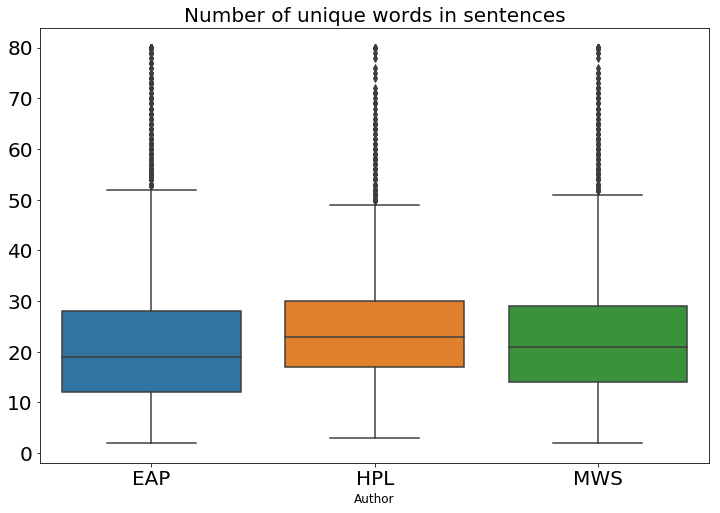

In [83]:
## Number of unique words in the text ##
df["num_unique_words"] = df["text"].apply(lambda x: len(set(str(x).split())))

boxplot_graph(df['author'], df["num_unique_words"], "Number of unique words in sentences", "Author", "", 80)
plt.show()

## Comment
Looking at the number of unique words used in sentences we can see that median is the highest for HPL again. Sentences written by EAP and MWS are pretty the same considering unique words.

The number of words in 50% of sentences is around 20-25 words. In 75% of the cases there is no more than 30 unique words in a sentence. Of course each outhor made some outliers which contains more than 60 words. Comparing words with unique words it is visible that some words are duplicated in sentences.

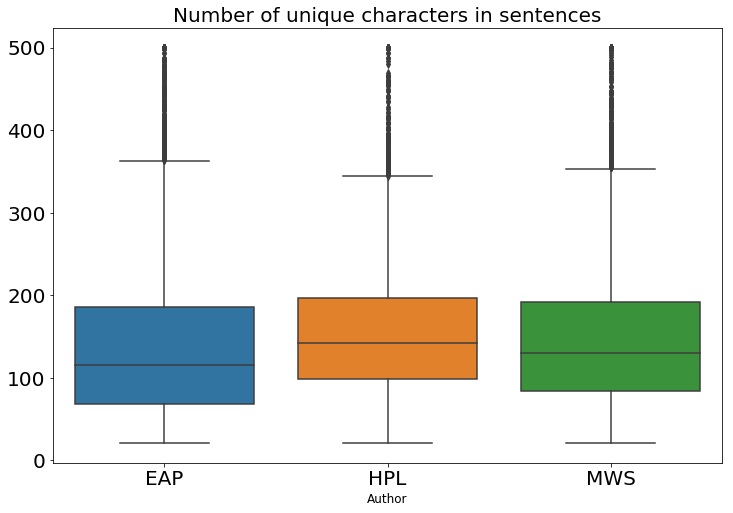

In [84]:
## Number of characters in the text ##
df["num_chars"] = df["text"].apply(lambda x: len(str(x)))

boxplot_graph(df['author'], df["num_chars"], "Number of unique characters in sentences", "Author", "", 500)
plt.show()

## Comment
Looking at the number of characters the situation is very simillar to number of unique words.

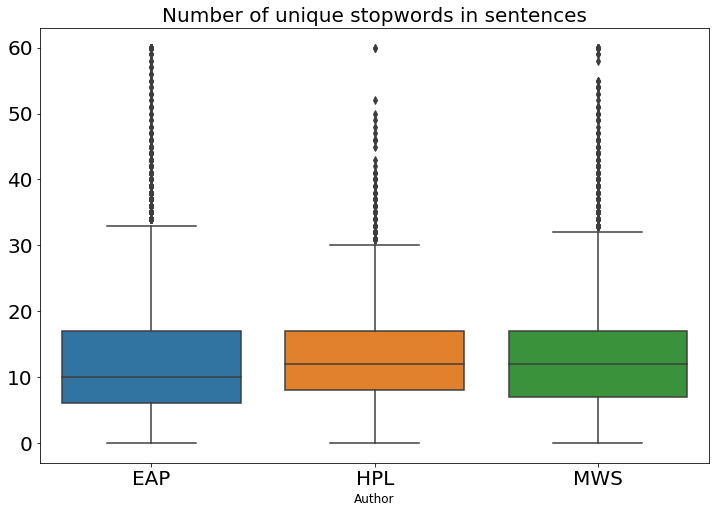

In [85]:
## Number of stopwords in the text ##
df["num_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

boxplot_graph(df['author'], df["num_stopwords"], "Number of unique stopwords in sentences", "Author", "", 60)
plt.show()

## Comment
The least stopwords are used un EAP sentences and the diversification is the highest for his sentences. 

The number of stopwords in 50% of sentences is around 10-12 words. In 75% of the cases there is no more than 18 stopwords in a sentence. If usually there is ~35 words in a sentence it means that one third of them set stopwords. 

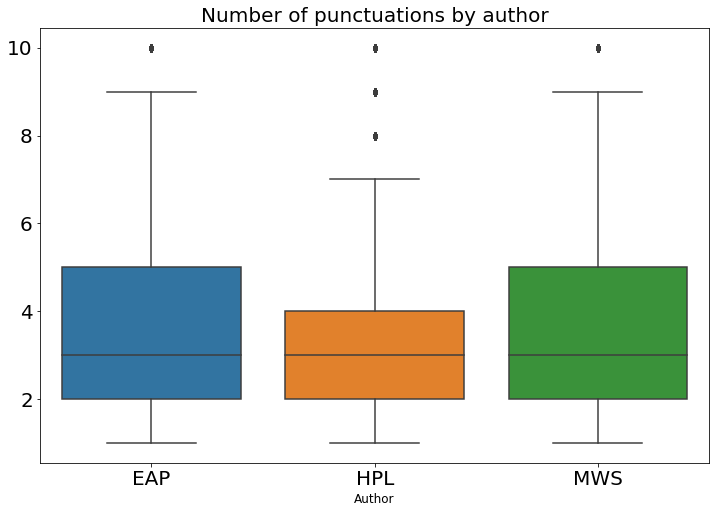

In [70]:
## Number of punctuations in the text ##
df["num_punctuations"] =df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

boxplot_graph(df['author'], df["num_punctuations"], "Number of punctuations by author", "Author", "", 10)
plt.show()

## Comment
For punctuation the median is almost the same for all authors however sentences written by HPL are less diversified than those coming from other authors.

The number of punctuation characters in 50% of sentences is around 3 characters. In 75% of the cases there is no more than 5 characters in a sentence. The longer the sentence is the more puntuation is used.

# Modeling

In [86]:
# Split dataset for train and test
train_text, test_text = train_test_split(df, test_size=0.4, random_state=7)

print('Train set: ' + str(train_text.id.nunique()))
print('Test set: ' + str(test_text.id.nunique()))

Train set: 11747
Test set: 7832


In [120]:
# Use count vectorizer on the cleaned data
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(train_text['text_cleaned_no_punct'])
X_test_counts = count_vect.transform(test_text['text_cleaned_no_punct'])

## Comment
The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

In [121]:
# Use tfidf
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## Comment
Word counts are a good starting point, but are very basic. We will use TF-IDF to calculate word frequencies.

In [126]:
# Using two different models to check whicjh performs better
clf_mnb = MultinomialNB().fit(X_train_tfidf, train_text.author)
clf_sdgc = SGDClassifier(max_iter=4000, tol=0.0001).fit(X_train_tfidf, train_text.author)

predicted_test_mnbt = clf_mnb.predict(X_test_tfidf)
predicted_test_sdgc = clf_sdgc.predict(X_test_tfidf)

In [127]:
print('Accuracy Score MNB = %s' %round(accuracy_score(test_text.author,predicted_test_mnbt),3))
print('Accuracy Score SGDC = %s' %round(accuracy_score(test_text.author,predicted_test_sdgc),3))

Accuracy Score MNB = 0.804
Accuracy Score SGDC = 0.803


## Comment
Both models are performing the same - we reach accuracy on the level of 80%. The sc ore seems quite good but definitely can be improved.

In [ ]:
# with open('app/models/model.pkl', 'wb') as f:
#     pickle.dump(clf_mnb, f)
    
# with open('app/count_vectorizer.pkl', 'wb') as f:
#     pickle.dump(count_vect, f)
    
# with open('app/tfidf_transformer.pkl', 'wb') as f:
#     pickle.dump(tfidf_transformer, f)

# Summary

## Dataset
Looking at the dataset we can see:

1. The dataset contains the most sentences which belong to EAP than to two other authors.
2. There are no missing values in the dataset.
3. Stopwords and punctuation is dominating sentences.
4. Mary writes about love and life. Having that the books which are mainly about this subject will most likely belong to her.
5. HP Lovecraft is writing about plaves and houses - he might create books about hounting places.
6. Usually HP Lovecraft is wiritng longers sentences than two other authors. The difference is not huge but might be crucial for modeling. 

## Modelling
We have the same accuracy for both models. I was playing a little bit with parameters and I was not abloe to achieve the accuracy higher than 80% for none of them.

As a next step what we could do:
- Fin
